# eye abnormalities classification
## model comparision between - baseline model (vs) feature extraction (vs) fine tuning 

In [1]:
# importing the necessary libraries

from tensorflow.keras.preprocessing import image 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import os 
import cv2
import pandas as pd
from PIL import Image
from pylab import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# getting the all the images in classes from the local folder

normal = 'D:\\AIML SEM 5\\eye_disease_dataset\\0_normal'
cataract = 'D:\\AIML SEM 5\\eye_disease_dataset\\2_cataract'
glaucoma = 'D:\\AIML SEM 5\\eye_disease_dataset\\3_glaucoma'
retina = 'D:\\AIML SEM 5\\eye_disease_dataset\\3_retina_disease'

In [4]:
# defining a function for augmenting the images from each folder to increase the number of images to 1000

def augmentation(folders):
    aug = []
    import Augmentor
    x = Augmentor.Pipeline(folders)
    x.rotate(probability = 0.7 , max_left_rotation = 10,max_right_rotation=10)
    x.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    aug.append(x.sample(1000))
    return aug

In [5]:
aug_norm = augmentation(normal)

Initialised with 377 image(s) found.
Output directory set to D:\AIML SEM 5\eye_disease_dataset\0_normal\output.

Processing <PIL.Image.Image image mode=RGB size=2592x1728 at 0x1D708CC4820>: 100%|██████████| 1000/1000 [05:15<00:00,  3.17 Samples/s]                 


In [6]:
aug_cat = augmentation(cataract)

Initialised with 389 image(s) found.
Output directory set to D:\AIML SEM 5\eye_disease_dataset\2_cataract\output.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x1D708C18D60>: 100%|██████████| 1000/1000 [01:43<00:00,  9.68 Samples/s]                 


In [7]:
aug_glaucoma = augmentation(glaucoma)

Initialised with 367 image(s) found.
Output directory set to D:\AIML SEM 5\eye_disease_dataset\3_glaucoma\output.

Processing <PIL.Image.Image image mode=RGB size=2592x1728 at 0x1D708BE2640>: 100%|██████████| 1000/1000 [01:51<00:00,  8.94 Samples/s]                 


In [61]:
aug_retina = augmentation(retina)

Initialised with 326 image(s) found.
Output directory set to D:\AIML SEM 5\eye_disease_dataset\3_retina_disease\output.

Processing <PIL.Image.Image image mode=RGB size=2124x2056 at 0x1D719C96F70>: 100%|██████████| 1000/1000 [02:58<00:00,  5.59 Samples/s]                 


### now the images are augmented and a new augmented dataset is created with 1000 images in each class

In [4]:
# getting the augmented dataset from the local folder created

augmented_normal = 'D:\\AIML SEM 5\\eye_disease_dataset\\0_normal\\output'
augmented_cataract = 'D:\\AIML SEM 5\\eye_disease_dataset\\2_cataract\\output'
augmented_glaucoma = 'D:\\AIML SEM 5\\eye_disease_dataset\\3_glaucoma\\output'
augmented_retina = 'D:\\AIML SEM 5\\eye_disease_dataset\\3_retina_disease\\output'

In [5]:
# getting the images as data and the respective class names as labels 

data = []
labels = []

for i in os.listdir(augmented_normal):
    image = plt.imread(augmented_normal+'\\'+i)
    image_size = cv2.resize(image , (100 , 100))
    data.append(image_size)
    labels.append(0)
for i in os.listdir(augmented_cataract):
    image = plt.imread(augmented_cataract+'\\'+i)
    image_size = cv2.resize(image , (100 , 100))
    data.append(image_size)
    labels.append(1)
for i in os.listdir(augmented_glaucoma):
    image = plt.imread(augmented_glaucoma+'\\'+i)
    image_size = cv2.resize(image , (100 , 100))
    data.append(image_size)
    labels.append(2)
for i in os.listdir(augmented_retina):
    image = plt.imread(augmented_retina+'\\'+i)
    image_size = cv2.resize(image , (100 , 100))
    data.append(image_size)
    labels.append(3)

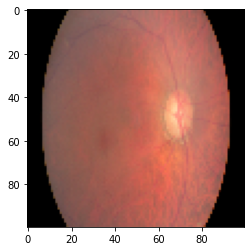

In [6]:
plt.imshow(data[2876])
plt.show()

In [7]:
image_data = np.array(data)
labels = np.array(labels)

In [8]:
index = np.arange(image_data.shape[0])

In [9]:
index

array([   0,    1,    2, ..., 3997, 3998, 3999])

In [10]:
np.random.shuffle(index)

In [11]:
image_data = image_data[index]
labels = labels[index]

In [13]:
# using train_test_split to split the data and labels for training and testing purposes

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.3, random_state = 50)

In [14]:
# libraries for model building 

from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [15]:
# defining a function for plotting the loss curves

import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


In [16]:
# confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=20, norm=False, savefig=False): 


  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [17]:
# one-hot encoding the train and test labels

y_train = np_utils.to_categorical(y_train, num_classes = 4)
y_test = np_utils.to_categorical(y_test, num_classes = 4)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten , Dense , Conv2D , MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras import applications

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [20]:
# using imagedatagenerator for model-augmentation purpose

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [21]:
datagen.fit(x_train)

## BASELINE MODEL

In [25]:
# building a baseline model 

model_1 = tf.keras.models.Sequential([
    Conv2D(filters=64, kernel_size=3,activation="relu", input_shape=(100, 100, 3)), 
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(pool_size=2,padding="valid"),
    Conv2D(32, 3, activation="relu"),
    MaxPool2D(pool_size=2,padding="valid"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2,padding="valid"),
    Conv2D(10, 3, activation="relu"), 
    MaxPool2D(pool_size=2,padding="valid"),
    Conv2D(10, 3, activation="relu"), 
    MaxPool2D(2),
    Flatten(),
    Dense(4, activation="softmax")
])

In [26]:
# compiling the baseline model

model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              metrics=["accuracy"])

In [27]:
# fitting the baseline model and storing the epoch values

history_1 = model_1.fit(datagen.flow(x_train, y_train, batch_size = 20,
                                subset = 'training'),
                        validation_data=datagen.flow(x_train, y_train,
                         batch_size=5, subset='validation'),
                        steps_per_epoch=len(x_train)//32, epochs=10)

Epoch 1/10
87/87 [==============================] - 25s 285ms/step - loss: 1.3444 - accuracy: 0.3402 - val_loss: 1.3104 - val_accuracy: 0.4375
Epoch 2/10
87/87 [==============================] - 24s 277ms/step - loss: 1.2845 - accuracy: 0.4264 - val_loss: 1.3300 - val_accuracy: 0.4107
Epoch 3/10
87/87 [==============================] - 24s 280ms/step - loss: 1.2344 - accuracy: 0.4632 - val_loss: 1.2005 - val_accuracy: 0.5143
Epoch 4/10
87/87 [==============================] - 25s 282ms/step - loss: 1.2007 - accuracy: 0.4925 - val_loss: 1.1327 - val_accuracy: 0.5607
Epoch 5/10
87/87 [==============================] - 25s 285ms/step - loss: 1.1672 - accuracy: 0.4977 - val_loss: 1.1482 - val_accuracy: 0.4000
Epoch 6/10
87/87 [==============================] - 25s 287ms/step - loss: 1.1549 - accuracy: 0.5224 - val_loss: 1.0681 - val_accuracy: 0.5929
Epoch 7/10
87/87 [==============================] - 25s 290ms/step - loss: 1.1297 - accuracy: 0.5362 - val_loss: 1.0483 - val_accuracy: 0.5946

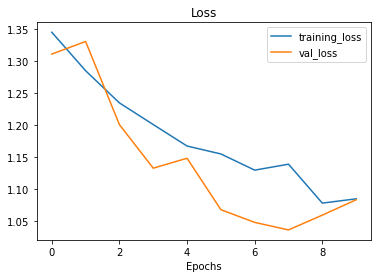

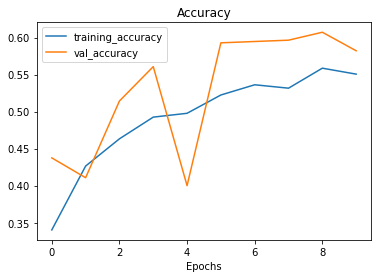

In [28]:
plot_loss_curves(history_1)

In [30]:
# defining the function for the printing the best accuracy of training and validation

def best_acc(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    accuracy = hist.history['accuracy']
    val_accuracy = hist.history['val_accuracy']
    print("The best Training accuracy {}".format(max(accuracy)*100))
    print("The best validation accuracy {} ".format(max(val_accuracy)*100))

In [31]:
best_acc(history_1)

The best Training accuracy 55.86206912994385
The best validation accuracy 60.71428656578064 


In [34]:
# defining a function for calculating the accuracy of the model on the test data

def test_acc(model_name):
    evaluation = model_name.evaluate(x_test , y_test)
    pred_prob = model_name.predict(x_test , verbose = 1)
    pred_classes = pred_prob.argmax(axis=1)
    y_test_labels = y_test.argmax(axis=1)
    acc = accuracy_score(y_test_labels , pred_classes)
    return acc

In [35]:
test_acc(model_1)

38/38 [==============================] - 3s 69ms/step


0.3591666666666667

In [39]:
pred_prob = model_1.predict(x_test , verbose = 1)
pred_classes = pred_prob.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

38/38 [==============================] - 3s 70ms/step


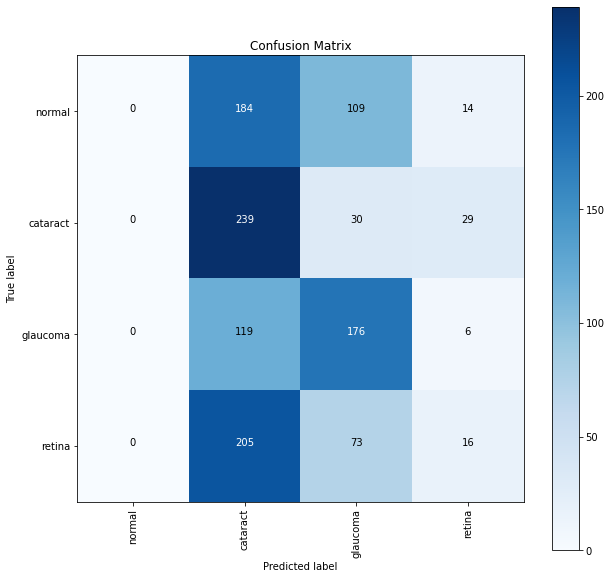

In [42]:
# plotting a confusion matrix for the model 

make_confusion_matrix(y_true=y_test_labels,
                      y_pred=pred_classes,
                      classes =['normal','cataract','glaucoma','retina'],
                      figsize=(10, 10),
                      text_size=10,
                      norm=False,
                      savefig=True)

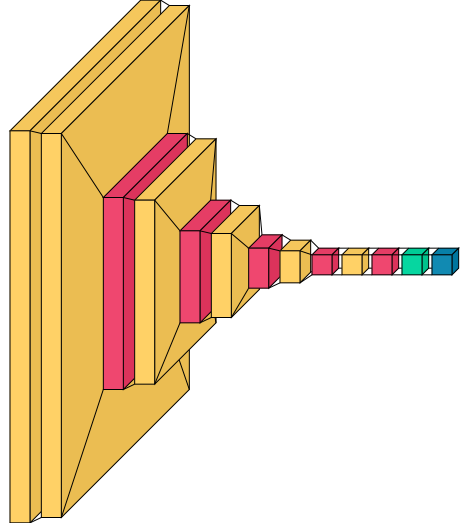

In [43]:
# visualizing the network structure of the baseline model

import visualkeras
visualkeras.layered_view(model_1)

## FEATURE EXTRACTION MODEL 

In [48]:
# building a vgg19 model for feature extraction 

model = tf.keras.applications.vgg19.VGG19(pooling = 'avg' , include_top=False,input_shape=(100 , 100, 3), weights='imagenet')
model.trainable = False

inputs = model.input
x = tf.keras.layers.Dense(128,activation = 'relu')(model.output)


outputs = tf.keras.layers.Dense(4 , activation = "softmax", name="op_layer")(x)

main_model = tf.keras.Model(inputs , outputs)

In [49]:
main_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [50]:
# compiling the feature extraction model using RMSprop and a lr = 0.001

main_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              metrics=["accuracy"])

In [51]:
history = main_model.fit(datagen.flow(x_train, y_train, batch_size = 20,
                                subset = 'training'),
                        validation_data=datagen.flow(x_train, y_train,
                         batch_size=5, subset='validation'),
                        steps_per_epoch=len(x_train)//32, epochs=10)

Epoch 1/10
87/87 [==============================] - 61s 703ms/step - loss: 1.1402 - accuracy: 0.5161 - val_loss: 1.0337 - val_accuracy: 0.6393
Epoch 2/10
87/87 [==============================] - 64s 732ms/step - loss: 0.9544 - accuracy: 0.6184 - val_loss: 0.9219 - val_accuracy: 0.6446
Epoch 3/10
87/87 [==============================] - 65s 744ms/step - loss: 0.9222 - accuracy: 0.6241 - val_loss: 0.9122 - val_accuracy: 0.6500
Epoch 4/10
87/87 [==============================] - 66s 760ms/step - loss: 0.8829 - accuracy: 0.6374 - val_loss: 0.8556 - val_accuracy: 0.6696
Epoch 5/10
87/87 [==============================] - 66s 758ms/step - loss: 0.8522 - accuracy: 0.6500 - val_loss: 0.8484 - val_accuracy: 0.6857
Epoch 6/10
87/87 [==============================] - 66s 761ms/step - loss: 0.8603 - accuracy: 0.6552 - val_loss: 0.7931 - val_accuracy: 0.7089
Epoch 7/10
87/87 [==============================] - 66s 763ms/step - loss: 0.8433 - accuracy: 0.6598 - val_loss: 0.8829 - val_accuracy: 0.6589

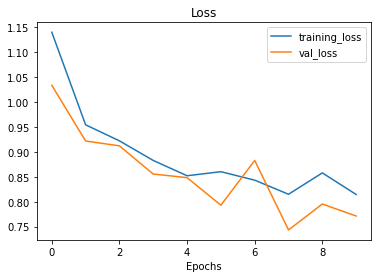

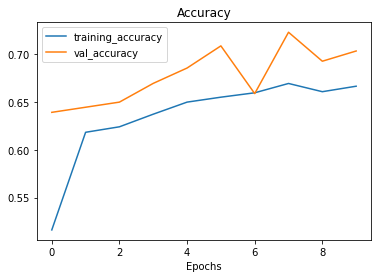

In [52]:
plot_loss_curves(history)

In [53]:
best_acc(history)

The best Training accuracy 66.95402264595032
The best validation accuracy 72.32142686843872 


In [54]:
test_acc(main_model)

38/38 [==============================] - 28s 740ms/step


0.45166666666666666

In [55]:
pred_prob = main_model.predict(x_test , verbose = 1)
pred_classes = pred_prob.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

38/38 [==============================] - 29s 750ms/step


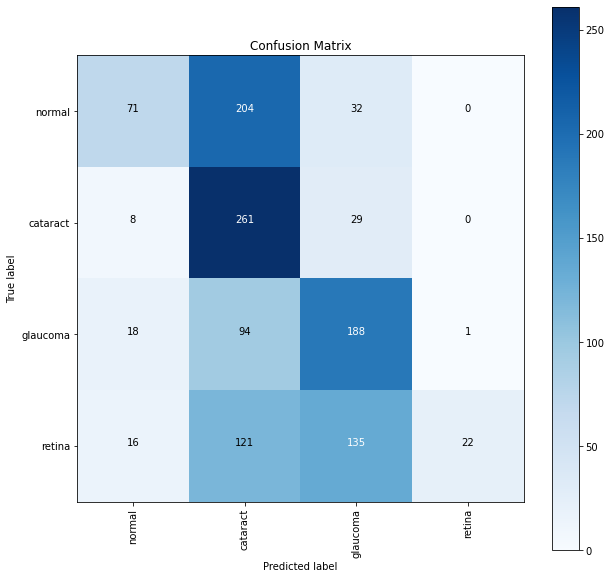

In [56]:
make_confusion_matrix(y_true=y_test_labels,
                      y_pred=pred_classes,
                      classes =['normal','cataract','glaucoma','retina'],
                      figsize=(10, 10),
                      text_size=10,
                      norm=False,
                      savefig=True)

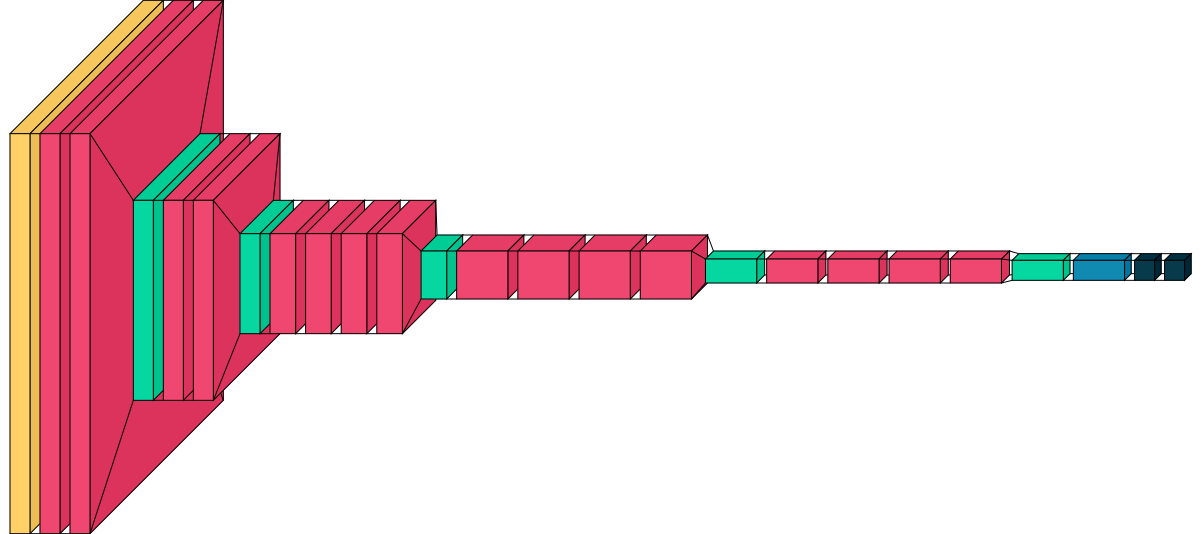

In [57]:
visualkeras.layered_view(main_model)

## FINE TUNING MODEL

In [58]:
# building a vgg19 model for fine tuning by unfreezing the last 5 layers of the model

model_2 = tf.keras.applications.vgg19.VGG19(pooling = 'avg' , include_top=False,input_shape=(100 , 100, 3), weights='imagenet')
model_2.trainable = True

# model = data_augmentation(inputs)
for layer in model_2.layers[:-5]:
  layer.trainable = False

inputs = model_2.input
x = tf.keras.layers.Dense(128,activation = 'relu')(model_2.output)


outputs = tf.keras.layers.Dense(4 , activation = "softmax", name="op_layer")(x)

main_model_2 = tf.keras.Model(inputs , outputs)

In [59]:
# compiling the fine tuning model using RMSprop and a lr = 0.0001

main_model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              metrics=["accuracy"])

In [60]:
history_2 = main_model_2.fit(datagen.flow(x_train, y_train, batch_size = 20,
                                subset = 'training'),
                        validation_data=datagen.flow(x_train, y_train,
                         batch_size=5, subset='validation'),
                        steps_per_epoch=len(x_train)//32, epochs=10)

Epoch 1/10
87/87 [==============================] - 73s 837ms/step - loss: 1.0186 - accuracy: 0.5868 - val_loss: 0.8179 - val_accuracy: 0.6893
Epoch 2/10
87/87 [==============================] - 78s 895ms/step - loss: 0.8293 - accuracy: 0.6672 - val_loss: 0.7807 - val_accuracy: 0.7125
Epoch 3/10
87/87 [==============================] - 79s 905ms/step - loss: 0.7998 - accuracy: 0.6839 - val_loss: 0.7206 - val_accuracy: 0.7393
Epoch 4/10
87/87 [==============================] - 80s 921ms/step - loss: 0.7444 - accuracy: 0.7092 - val_loss: 0.6951 - val_accuracy: 0.7357
Epoch 5/10
87/87 [==============================] - 81s 927ms/step - loss: 0.7299 - accuracy: 0.7149 - val_loss: 0.6782 - val_accuracy: 0.7446
Epoch 6/10
87/87 [==============================] - 81s 932ms/step - loss: 0.7066 - accuracy: 0.7276 - val_loss: 0.6499 - val_accuracy: 0.7571
Epoch 7/10
87/87 [==============================] - 83s 955ms/step - loss: 0.6984 - accuracy: 0.7236 - val_loss: 0.6662 - val_accuracy: 0.7589

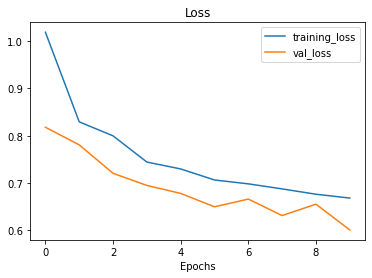

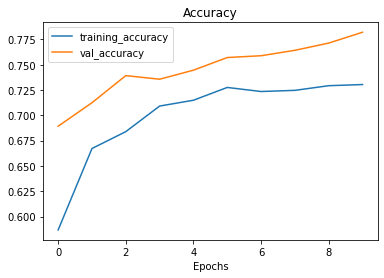

In [61]:
plot_loss_curves(history_2)

In [62]:
best_acc(history_2 )

The best Training accuracy 73.04597496986389
The best validation accuracy 78.21428775787354 


In [63]:
test_acc(main_model_2)

38/38 [==============================] - 31s 827ms/step


0.6058333333333333

In [64]:
pred_prob = main_model_2.predict(x_test , verbose = 1)
pred_classes = pred_prob.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

38/38 [==============================] - 33s 863ms/step


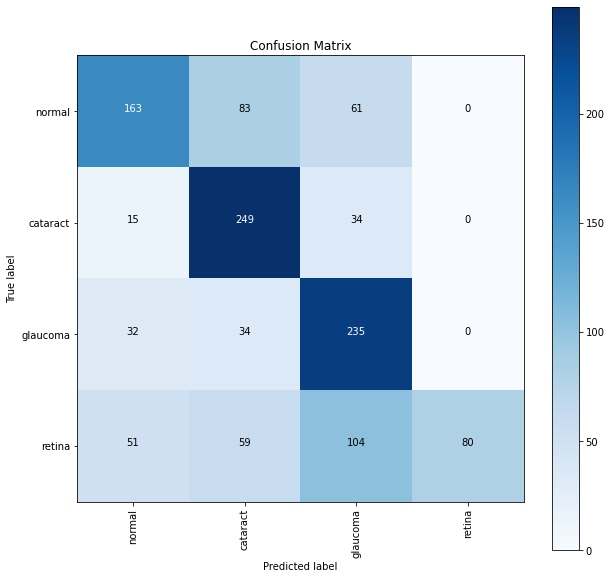

In [65]:
make_confusion_matrix(y_true=y_test_labels,
                      y_pred=pred_classes,
                      classes =['normal','cataract','glaucoma','retina'],
                      figsize=(10, 10),
                      text_size=10,
                      norm=False,
                      savefig=True)

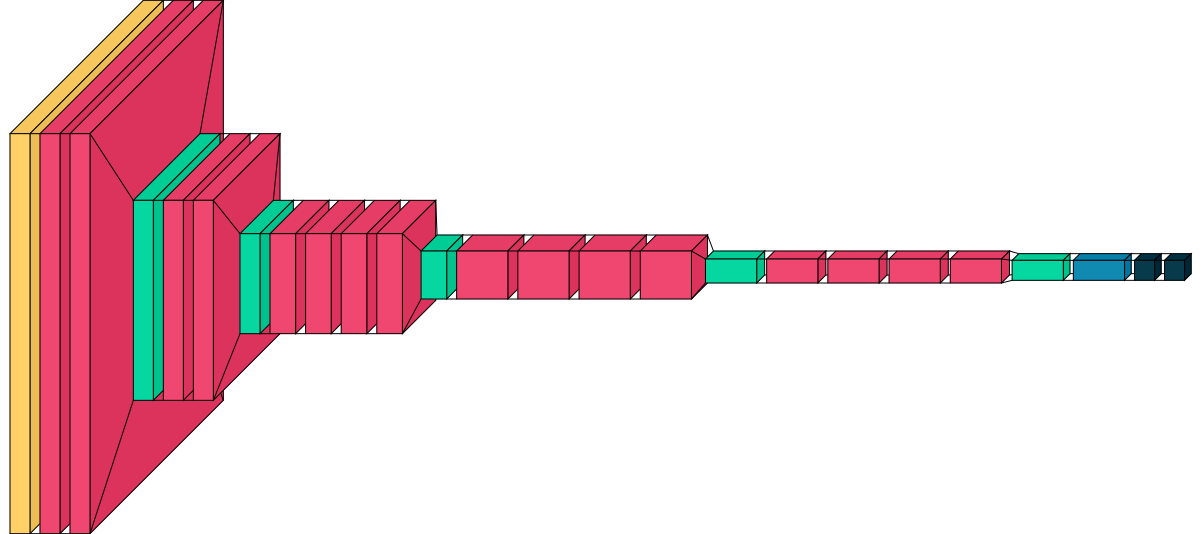

In [66]:
visualkeras.layered_view(main_model_2)

# 

## test accuracy of baseline model = 35.91
## test accuracy of vgg19 (feature extraction model) = 45.16
## test accuracy of vgg19 (fine tuning model) = 60.58